### If you have any suggestions, or find bugs, create a jira ticket:
https://bbpteam.epfl.ch/project/issues/projects/ACCS/issues/?filter=allopenissues

We begin by loading a circuit

In [1]:
import pandas
import numpy
import bluepy

circ_fn = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_TC_WM"
circ = bluepy.Circuit(circ_fn)

New we load basic information about neurons into a DataFrame.
To that end, a "load_neurons" function is offered. Its basic functionality is just forwarding arguments to 
Circuit.cells.get(), but in addition it offers the extraction of flat coordinates and supersampled flat coordinates.

In [2]:
# install the following repo from: bbpgitlab.epfl.ch:conn/structural/Connectome-utilities.git
# Note: There is more documentation in that repo!
from conntility.circuit_models import neuron_groups

base_grp = neuron_groups.load_neurons(circ, ["x", "y", "z", "layer", "mtype", "etype"]
                                      + neuron_groups.FLAT_COORDINATES  # Add basic flat coords (i.e. integers)
                                     + neuron_groups.SS_COORDINATES,  # Add superampled flat coords (i.e. in um)
                                     base_target="Layer5")  # If not provided: loads all neurons

display(base_grp)

/gpfs/bbp.cscs.ch/home/reimann/venvs/py38/lib/python3.8/site-packages/conntility/flatmapping/_supersample_utility.py:136: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  res = Rotation.align_vectors(vtgt, vv)


Rotation errors: min: 0.0, median: 0.09387602600937471, mean: 0.136282418448154, std: 0.15664142313801505, max: 2.0


,etype,layer,mtype,x,y,z,gid,flat_x,flat_y,ss_flat_x,depth,ss_flat_y
0,cACint,5,L5_CHC,4983.375763,-1341.435998,-5016.611538,3422034,114,16,3892.121095,1018.662903,610.067132
1,cNAC,5,L5_CHC,5039.618853,-664.256231,-3132.049422,3422035,85,67,2896.617817,785.472502,2316.558890
2,cACint,5,L5_CHC,3154.281591,-1978.658619,-1809.539025,3422036,3,70,76.265644,863.001974,2395.208037
3,cNAC,5,L5_CHC,5496.030499,1932.811127,-4179.964811,3422037,158,105,5396.522767,1207.114934,3618.855012
4,cACint,5,L5_CHC,3943.767463,-1981.865942,-2748.373469,3422038,35,50,1193.627575,1185.606134,1711.952359
...,...,...,...,...,...,...,...,...,...,...,...,...
812891,cNAC,5,L5_BP,4509.475274,-2362.381286,-4218.200359,4234925,70,15,2413.104513,950.513726,507.814824
812892,bNAC,5,L5_BP,5481.109969,1600.112153,-4327.481596,4234926,156,94,5308.522937,1158.415307,3229.684437
812893,cACint,5,L5_BP,2013.692376,1964.270177,-1345.768408,4234927,22,184,743.119256,936.466383,6282.706079
812894,bNAC,5,L5_BP,3194.431573,786.250809,-1621.000855,4234928,42,140,1437.155977,875.651399,4820.146454


Note that the result is not indexed by gid! The reason for that will become clear soon: We will define 
groups (or targets) of neurons by adding MultiIndices to the DataFrame. Therefore, this first, default index is
a meaningless RangeIndex.

But first let's do some sanity checks on the consistency of the flat coordinates

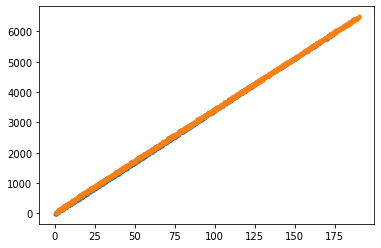

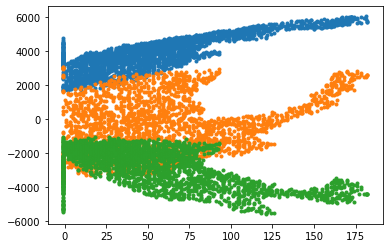

In [3]:
from matplotlib import pyplot as plt

rnd_idxx = numpy.random.choice(len(base_grp), 2500, replace=False)

ax = plt.figure().gca()
ax.plot(base_grp["flat_x"][rnd_idxx], base_grp["ss_flat_x"][rnd_idxx], '.')
ax.plot(base_grp["flat_y"][rnd_idxx], base_grp["ss_flat_y"][rnd_idxx], '.')

ax = plt.figure().gca()
ax.plot(base_grp["flat_x"][rnd_idxx], base_grp["x"][rnd_idxx], '.')
ax.plot(base_grp["flat_x"][rnd_idxx], base_grp["y"][rnd_idxx], '.')
ax.plot(base_grp["flat_x"][rnd_idxx], base_grp["z"][rnd_idxx], '.')

Definition if neuron groups follows a simple patterns: Providing a DataFrame as input, a copy of the frame is returned
with a MultiIndex that determines which group a neuron belongs to.

Crucially, this step can be repeated to "tack on" another grouping. For that use case, set replace=False, otherwise the new index will replace the previous one. This way we grouped neurons into individual mtypes within 200 um hexes.

The names of the new targets can be "prefix"ed to ensure uniqueness. (This may be relevant for example if you want to define multiple grids of different resolution simultaneously).

In [4]:
# EXPERIMENTS
grp = neuron_groups.group_by_properties(base_grp, ["layer", "mtype", "etype"], prefix="by-")
grp = grp.iloc[numpy.random.choice(len(grp), 5000, replace=False)]
grp1 = grp.droplevel("by-mtype")
grp2 = grp.droplevel("by-etype")

display(grp)
circ.cells.count()

etype  layer     mtype            x            y  \
by-layer by-mtype by-etype                                                      
5        L5_TPC:A cADpyr    cADpyr      5  L5_TPC:A  4735.496681 -1111.851346   
                  cADpyr    cADpyr      5  L5_TPC:A  5272.969451  -476.285419   
                  cADpyr    cADpyr      5  L5_TPC:A  3750.942549   787.443590   
         L5_LBC   dSTUT      dSTUT      5    L5_LBC  4795.451438  -602.353466   
         L5_TPC:B cADpyr    cADpyr      5  L5_TPC:B  4839.196584 -1312.981754   
...                            ...    ...       ...          ...          ...   
         L5_LBC   dSTUT      dSTUT      5    L5_LBC  2714.582466   858.709583   
         L5_TPC:A cADpyr    cADpyr      5  L5_TPC:A  4412.169864 -2130.482183   
                  cADpyr    cADpyr      5  L5_TPC:A  5004.665332 -1139.239008   
         L5_TPC:B cADpyr    cADpyr      5  L5_TPC:B  2619.996518 -1488.386539   
         L5_TPC:C cADpyr    cADpyr      5  L5_TPC:C  4218.527920 -2613.532712   

                                      z      gid  flat_x  flat_y    ss_flat_x  \
by-layer by-mtype by-etype                                                      
5        L5_TPC:A cADpyr   -3807.081387  3876292      87      46  2983.963380   
                  cADpyr   -4565.570154  4186109     125      40  4248.762217   
                  cADpyr   -2017.580741  4208583      61     129  2082.511585   
         L5_LBC   dSTUT    -3562.513993  3486755      91      61  3134.625870   
         L5_TPC:B cADpyr   -4041.567842  3745361      90      38  3055.337446   
...                                 ...      ...     ...     ...          ...   
         L5_LBC   dSTUT    -1781.298301  3500970      31     149  1049.652223   
         L5_TPC:A cADpyr   -3862.889666  3999812      63      27  2129.514179   
                  cADpyr   -3859.503569  3911832      91      45  3085.540309   
         L5_TPC:B cADpyr   -2071.637108  3658008       1      88    20.377516   
         L5_TPC:C cADpyr   -3717.185423  3448963      47      19  1617.575636   

                                  depth    ss_flat_y  
by-layer by-mtype by-etype                            
5        L5_TPC:A cADpyr    1163.839617  1581.513887  
                  cADpyr    1059.291614  1384.824804  
                  cADpyr     994.118560  4449.701319  
         L5_LBC   dSTUT     1136.703252  2100.569452  
         L5_TPC:B cADpyr    1159.563876  1324.340003  
...                                 ...          ...  
         L5_LBC   dSTUT     1154.821157  5083.873109  
         L5_TPC:A cADpyr    1188.981192   963.957526  
                  cADpyr     952.324466  1583.250251  
         L5_TPC:B cADpyr    1107.086430  3002.196720  
         L5_TPC:C cADpyr    1087.765188   692.826105  

[5000 rows x 12 columns]

4234929

In [29]:
import tqdm, h5py
from scipy.spatial import distance
from scipy import sparse
from conntility.circuit_models.connection_matrix import LOCAL_CONNECTOME, find_sonata_connectome, full_connection_matrix

def connection_matrix_for_gids(sonata_fn, gids, gids_post=None):
    idx = numpy.array(gids) - 1  # From gids to sonata "node" indices (base 0 instead of base 1)
    h5 = h5py.File(sonata_fn, "r")['edges/default']  # TODO: Instead of hard coding "default" that could be a config parameter
    if gids_post is None:
        gids_post = gids
    idx_post = numpy.array(gids_post) - 1
    N = len(gids)
    M = len(gids_post)

    indices = []
    indptr = [0]
    for id_post in tqdm.tqdm(idx_post):
        ids_pre = []
        ranges = h5['indices']['target_to_source']['node_id_to_ranges'][id_post, :]
        for block in h5['indices']['target_to_source']['range_to_edge_id'][ranges[0]:ranges[1], :]:
            ids_pre.append(h5['source_node_id'][block[0]:block[1]])
        if len(ids_pre) > 0:
            row_ids = numpy.nonzero(numpy.in1d(idx, numpy.hstack(ids_pre)))[0]
            indices.extend(row_ids)
        indptr.append(len(indices))
    mat = sparse.csc_matrix((numpy.ones(len(indices), dtype=bool), indices, indptr), shape=(N, M))
    return mat

def circuit_connection_matrix(circ, connectome=LOCAL_CONNECTOME, for_gids=None, for_gids_post=None, chunk=50000000):
    conn_file = find_sonata_connectome(circ, connectome)
    N = circ.cells.count()
    if for_gids is None:
        return full_connection_matrix(conn_file, n_neurons=N, chunk=chunk)
    return connection_matrix_for_gids(conn_file, for_gids, gids_post=for_gids_post)

def prepare_distance(df_pre):
    def execute_distance(df_post):
        return distance.cdist(df_pre[["x", "y", "z"]], df_post[["x", "y", "z"]])
    return execute_distance

def prepare_overlap(df_pre):
    def execute_overlap(df_post):
        return len(numpy.intersect1d(df_pre["gid"], df_post["gid"]))
    return execute_overlap

def prepare_con_mat(df_pre):
    def execute_con_mat(df_post):
        return circuit_connection_matrix(circ, for_gids=df_pre["gid"].values, for_gids_post=df_post["gid"].values)
    return execute_con_mat

res = grp1.groupby(grp1.index.names).apply(
    lambda df_pre:
    grp2.groupby(grp2.index.names).apply(prepare_con_mat(df_pre))
)

100%|██████████| 281/281 [00:00<00:00, 351.43it/s]


In [34]:
res[5, "L5_MC"][5, "bAC"]

<85x103 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Column format>

In [40]:
from conntility import ConnectivityMatrix
from conntility.connectivity import ConnectivityGroup
from conntility.connectivity import LOCAL_CONNECTOME


loader_config = {
    "loading": {
        "base_target": "central_column_4_region_700um", 
        "properties": ["x", "y", "z", "etype", "mtype", "layer", "synapse_class", "ss_flat_x", "ss_flat_y"]
    },
    "filtering":[
        {
            "column": "synapse_class",
            "value": "INH"
        }
    ],
    "grouping": [
        {
            "method": "group_by_grid",
            "columns": ["ss_flat_x", "ss_flat_y"],
            "args": [200.0],
            "kwargs":{
                "prefix": "hex200-"                
            }
        }
    ]
}

G = ConnectivityGroup.from_bluepy(circ, loader_config, connectome=LOCAL_CONNECTOME)

/gpfs/bbp.cscs.ch/home/reimann/venvs/py38/lib/python3.8/site-packages/conntility/flatmapping/_supersample_utility.py:136: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  res = Rotation.align_vectors(vtgt, vv)


Rotation errors: min: 0.0, median: 0.09387602600937471, mean: 0.136282418448154, std: 0.15664142313801505, max: 2.0


 37%|███▋      | 106/286 [00:01<00:02, 77.91it/s]


KeyboardInterrupt: 

idx-mtype_post    L1_DAC    L1_HAC    L1_LAC  L1_NGC-DA  L1_NGC-SA    L1_SAC  \
idx-mtype_pre                                                                  
L1_DAC          0.022654  0.022727  0.028249   0.018617   0.017136  0.012146   
L1_HAC          0.010997  0.016032  0.010025   0.020161   0.021628  0.014164   
L1_LAC          0.022599  0.020050  0.000000   0.028302   0.034483  0.020690   
L1_NGC-DA       0.034574  0.026613  0.031447   0.026019   0.022192  0.014444   
L1_NGC-SA       0.013464  0.006261  0.004310   0.004707   0.009588  0.006329   
L1_SAC          0.014170  0.010387  0.000000   0.002222   0.007911  0.005435   
L23_BP          0.000000  0.000597  0.000000   0.000000   0.000000  0.000000   
L23_BTC         0.010880  0.008505  0.006897   0.007050   0.005311  0.014888   
L23_CHC         0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
L23_DBC         0.005063  0.002990  0.000000   0.001409   0.000000  0.001631   
L23_LBC         0.006867  0.006423  0.00

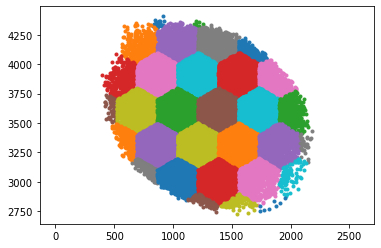

In [37]:
for idx in G.index:
    M = G[idx]
    plt.plot(M.vertices["ss_flat_x"], M.vertices["ss_flat_y"], '.')
plt.axis("equal")

M = G[(-15, 21)]
res = M.analyze("/gpfs/bbp.cscs.ch/home/reimann/code/danielas_analyses/analysis_configs/connection_prob_for_pathways.json")

con_prob = res["con_prob_within_200"]
print(con_prob.unstack("idx-mtype_post"))

In [38]:
grps = neuron_groups.group_by_properties(base_grp, # frame with neuron information. First arg for all groupers
                                         ["mtype"], # list of columns to use for grouping. Second arg for all groupers
                                         prefix="by-")  # a kwarg for all groupers
grps = neuron_groups.group_by_grid(grps,  # frame with existing grouping!
                                   ["ss_flat_x", "ss_flat_y"], # list of columns to use for grouping.
                                   200.0,  # Radius of grid. Specific to this grouper
                                   shape="hexagonally",  # Shape of grid. "hex" is also the default
                                   prefix="hex_200-", # a kwarg for all groupers
                                   replace=False)  # So that the new group is tacked on instead of replacing the old
display(grps)

etype  layer   mtype            x            y  \
by-mtype hex_200-i hex_200-j                                                    
L5_BP    -7        8            cNAC      5   L5_BP  3444.749392 -2584.448130   
         -15       27           bNAC      5   L5_BP  3869.090889   725.037941   
         -25       38         cACint      5   L5_BP  3203.175620  2655.088344   
         -5        22           cNAC      5   L5_BP  4882.678976  -300.953914   
         -27       30           bNAC      5   L5_BP  2279.903869  1084.264844   
...                              ...    ...     ...          ...          ...   
L5_UPC   -9        21         cADpyr      5  L5_UPC  4024.600572  -351.577544   
          1        16         cADpyr      5  L5_UPC  5013.021919 -1375.294287   
         -3        18         cADpyr      5  L5_UPC  4628.692337  -901.991471   
          0        21         cADpyr      5  L5_UPC  5280.748326  -470.570847   
         -8        19         cADpyr      5  L5_UPC  4361.545063  -831.716522   

                                        z      gid  flat_x  flat_y  \
by-mtype hex_200-i hex_200-j                                         
L5_BP    -7        8         -2110.472539  4234929       5      46   
         -15       27        -1959.181868  4232611      63     128   
         -25       38        -1356.082595  4232610      69     185   
         -5        22        -2988.191706  4232609      85      78   
         -27       30        -1512.882123  4232608      17     163   
...                                   ...      ...     ...     ...   
L5_UPC   -9        21        -2661.797886  3525017      60      91   
          1        16        -3631.127790  3525016      83      44   
         -3        18        -3316.895946  3525015      78      62   
          0        21        -3555.634594  3525028     102      62   
         -8        19        -2493.387248  3546379      58      77   

                                ss_flat_x        depth    ss_flat_y  \
by-mtype hex_200-i hex_200-j                                          
L5_BP    -7        8           178.131446   934.253932  1608.716589   
         -15       27         2113.197868   920.384664  4367.879397   
         -25       38         2330.271700   737.542234  6294.973608   
         -5        22         2892.788392   993.727069  2706.019449   
         -27       30          557.219042   965.431684  5581.473531   
...                                   ...          ...          ...   
L5_UPC   -9        21         2022.777122  1355.617731  3125.434925   
          1        16         2839.203798   852.045178  1507.312826   
         -3        18         2625.436155  1100.972343  2123.851721   
          0        21         3469.993034   846.507891  2110.652715   
         -8        19         1994.847882   851.537585  2653.729680   

                                hex_200-x  hex_200-y hex_200-subtarget  
by-mtype hex_200-i hex_200-j                                            
L5_BP    -7        8           173.205081     1500.0             R5;C0  
         -15       27         2078.460969     4200.0            R14;C6  
         -25       38         2251.666050     6300.0            R21;C6  
         -5        22         2944.486373     2700.0             R9;C8  
         -27       30          519.615242     5700.0            R19;C1  
...                                   ...        ...               ...  
L5_UPC   -9        21         2078.460969     3000.0            R10;C6  
          1        16         2944.486373     1500.0             R5;C8  
         -3        18         2598.076211     2100.0             R7;C7  
          0        21         3637.306696     2100.0            R7;C10  
         -8        19         1905.255888     2700.0             R9;C5  

[812896 rows x 15 columns]

This representation of neuron groups can be used to extract the connection matrices within each group.
To that end, circuit_models.connection_matrix is a module offering this functionality.

Here, we limit this to the groups of one mtype, using the .loc operator. I.e., we extract connectivity only within L5_BPs in a hex. Because this is just for demonstration.

In [ ]:
from conntility.circuit_models.connection_matrix import circuit_group_matrices, LOCAL_CONNECTOME
M = circuit_group_matrices(circ,
                           grps.loc["L5_BP"],  # Limiting this to L5_BPs. Could also do all groups...
                           connectome=LOCAL_CONNECTOME)  # If anything but LOCAL_CONNECTOME is provided, it
#  will instead use Circuit.projection(connectome) to find the file to read from.
display(M)

We can save and load this representation of connection matrices using provided functionality

In [ ]:
from conntility.io import write_toc_plus_payload,read_toc_plus_payload
write_toc_plus_payload(M, ("test_write_sparse_matrices.h5", "test"))

M_loaded = read_toc_plus_payload(("test_write_sparse_matrices.h5", "test"))
display(M_loaded)

Basic sanity check that the loaded matrices have the same number of edges as the originals

In [ ]:
sum_original = M.apply(lambda x: x.sum())
sum_after = M_loaded.apply(lambda x: x.matrix.sum())

print(list(zip(sum_original, sum_after)))

Instead of connectivity within the groups, we can also extract connectivity between the groups. The following counts the number of synapses between neurons in the groups.

As before, we limit this to L5_BP

In [ ]:
from conntility.circuit_models.connection_matrix import circuit_matrix_between_groups

N = circuit_matrix_between_groups(circ, grps.loc["L5_BP"])
display(N)

The result is in the form of a Series of synapse counts, index by Source and Target node. The names of nodes are contracted version of their index in the grouping. E.g. hex_200-i=10, hex_200-j=11 will be "10_11". Might find a better solution for this in the future.  

The following line can be used to turn this into a more classic connection matrix.

In [ ]:
N.reset_index().pivot(index="Target node", columns="Source node", values=N.name)

We can also use "neuron_groups" to load the locations of input fibers, as well as their flat locations!
At the moment this requires a second step, where the flat coordinates are added by a call to "add_extra_properties". This will be improved in the future.

Note that this automatically handles offsetting the locations of fibers by 1500 um to move them "into" the flat map.

In [ ]:
from conntility.circuit_models.neuron_groups import load_projection_locations
from conntility.circuit_models.neuron_groups.extra_properties import add_extra_properties

proj = load_projection_locations(circ, "Thalamocortical_input_VPM")  # Circuit and name of projection
proj = add_extra_properties(proj, circ,
                            neuron_groups.SS_COORDINATES  # Same as for neurons!
                            + neuron_groups.FLAT_COORDINATES) # Same as for neurons!

display(proj)

Note that this representation is very similar to the representation of neurons. Only the names of columns are different.

Let's begin by conducting the same sanity checks as for the neurons

In [ ]:
from matplotlib import pyplot as plt

rnd_idxx = numpy.random.choice(len(proj), 2500, replace=False)

ax = plt.figure().gca()
ax.plot(proj["flat_x"][rnd_idxx], proj["ss_flat_x"][rnd_idxx], '.')
ax.plot(proj["flat_y"][rnd_idxx], proj["ss_flat_y"][rnd_idxx], '.')

ax = plt.figure().gca()
ax.plot(proj["flat_x"][rnd_idxx], proj["x"][rnd_idxx], '.')
ax.plot(proj["flat_x"][rnd_idxx], proj["y"][rnd_idxx], '.')
ax.plot(proj["flat_x"][rnd_idxx], proj["z"][rnd_idxx], '.')

Because the representation of the fibers is similar to the neurons, we can use the same functionality to generate groups!

In [ ]:
proj_grp = neuron_groups.group_by_properties(proj, ["apron"])
proj_grp = neuron_groups.group_by_grid(proj_grp, neuron_groups.SS_COORDINATES, 200, replace=False)

display(proj_grp)

For example, these are hexagons of TC fibers:

In [ ]:
ax = plt.figure().gca()

def plot_a_hex(df_in):
    ax.plot(df_in["ss_flat_x"], df_in["ss_flat_y"], '.')

proj_grp.groupby(proj_grp.index.names).apply(plot_a_hex)